<a href="https://colab.research.google.com/github/dedeikhsan/Ensemble-MobileNetV2-and-EfficientNetB7/blob/main/Ensemble_Stack_(Lr_0%2C001).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementasi Ensemble Learning dengan Arsitektur MobileNetV2 dan EfficientNetB7 Pada Klasifikasi Citra Penyakit Kanker Kulit**
---

Penelitian ini bertujuan untuk membuat model yang memiliki akurasi dan performa terbaik menggunakan Ensemble Learning dengan Arsitektur MobileNetV2 dan EfficientNet.

Studi kasus yang digunakan pada penelitian ini adalah penyakit kanker kulit. Dataset yang digunakan merupakan gambar penyakit onkologi ganas dan jinak, yang dibentuk dari The International Skin Imaging Collaboration (ISIC). Semua gambar disortir menurut klasifikasi yang diambil dengan ISIC, dan semua subset dibagi menjadi jumlah gambar yang sama. Jumlah keseluruhan dataset yang digunakan pada penelitian ini adalah 2193 gambar pada masing-masing jenis penyakit. Kumpulan dataset berisi penyakit antara lain:


*   Basal Cell Carcinoma
*   Melanoma
*   Squamous Cell Carcinoma



## Install Tensorflow 2.9.1

Menggunakan versi 2.9.1 karena arsitektur EfficientNetB7 lebih kompatibel menggunakan versi ini

In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 55.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorf

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.1


## Import Library

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img

## Import Dataset Via Gdrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Pre Processing

In [5]:
train_dir = pathlib.Path("/content/drive/MyDrive/Skin Cancer Coba/Train")
# test_dir = pathlib.Path("/content/drive/MyDrive/Dataset/Skin cancer ISIC/Test")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [6]:
# Akuisisi Data Training
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2193 files belonging to 3 classes.
Using 1755 files for training.


In [7]:
# Akuisisi Data Validation
validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2193 files belonging to 3 classes.
Using 438 files for validation.


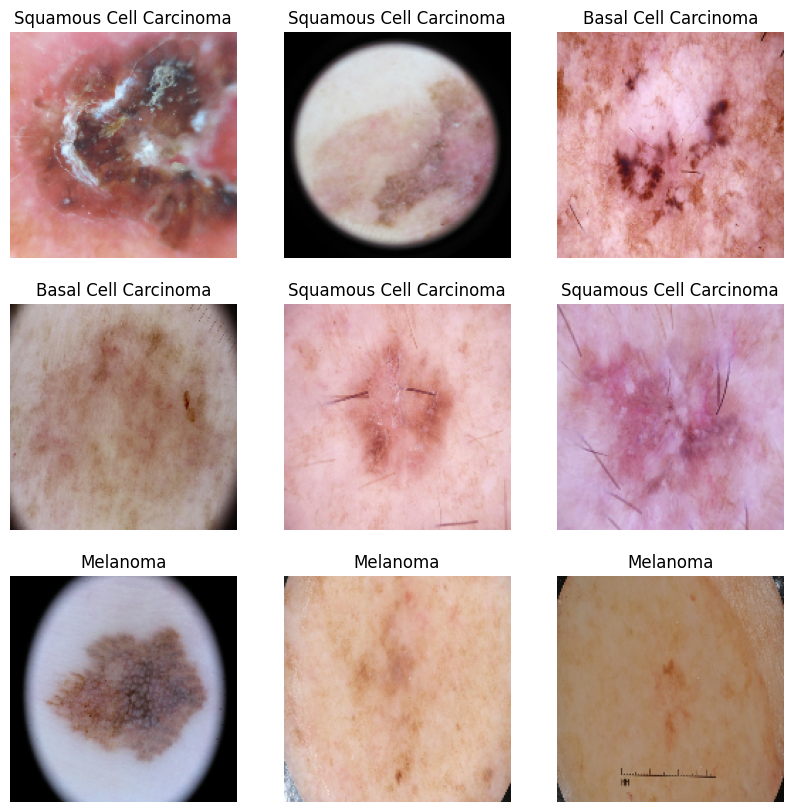

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Identifikasi Ketidakseimbangan Data

Total Data Training = 2193 

-------------------------------------
Nama Class  =  Basal Cell Carcinoma
Jumlah      =  735
Proporsi    =  0.33515731874145005
-------------------------------------
Nama Class  =  Melanoma
Jumlah      =  737
Proporsi    =  0.33606931144550845
-------------------------------------
Nama Class  =  Squamous Cell Carcinoma
Jumlah      =  721
Proporsi    =  0.3287733698130415
-------------------------------------


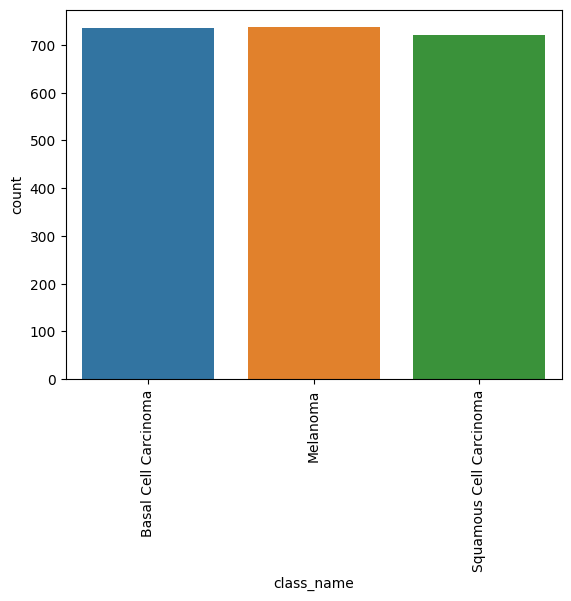

In [9]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  total += count
print("Total Data Training = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  print("Nama Class  = ",class_names[i])
  print("Jumlah      = ",count)
  print("Proporsi    = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

### Augmentor Untuk Menyeimbangkan Data

In [10]:
#Menginstall augmentor
!pip install Augmentor

In [11]:
#Import augmentor yang telah diinstal
import Augmentor

#Set hyperparameter untuk disesuaikan pada setiap class
for i in class_names:
    p = Augmentor.Pipeline(source_directory = os.path.join(train_dir, i), output_directory = '/content/output/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(3000)

Initialised with 735 image(s) found.
Output directory set to /content/output/Basal Cell Carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F67B00CDBA0>: 100%|██████████| 3000/3000 [01:19<00:00, 37.56 Samples/s]


Initialised with 737 image(s) found.
Output directory set to /content/output/Melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x680 at 0x7F67D8767190>: 100%|██████████| 3000/3000 [03:58<00:00, 12.60 Samples/s]


Initialised with 721 image(s) found.
Output directory set to /content/output/Squamous Cell Carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F6865E49E10>: 100%|██████████| 3000/3000 [02:05<00:00, 23.94 Samples/s]


In [12]:
output_dir = pathlib.Path('/content/output')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


Total Data Training Setelah Menggunakan Augmentor = 9000 

-------------------------------------
Nama Class =  Basal Cell Carcinoma
Jumlah      =  3000
Proporsi =  0.3333333333333333
-------------------------------------
Nama Class =  Melanoma
Jumlah      =  3000
Proporsi =  0.3333333333333333
-------------------------------------
Nama Class =  Squamous Cell Carcinoma
Jumlah      =  3000
Proporsi =  0.3333333333333333
-------------------------------------


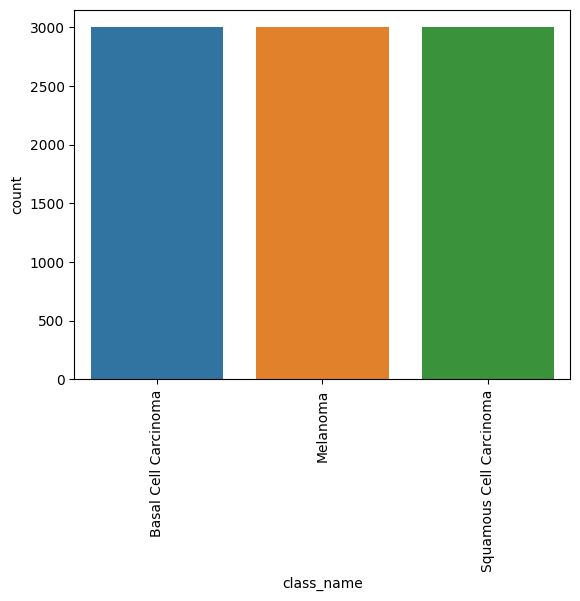

In [13]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("Total Data Training Setelah Menggunakan Augmentor = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Nama Class = ",class_names[i])
  print("Jumlah      = ",count)
  print("Proporsi = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

###  Data Seimbang

In [14]:
train_dataset = tf.keras.utils.image_dataset_from_directory(output_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 9000 files belonging to 3 classes.
Using 7200 files for training.


In [15]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(output_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 9000 files belonging to 3 classes.
Using 1800 files for validation.


### Membuat Test Set

Test set diambil dari validation dataset yang mengambil 20% untuk dipindahkan ke test set

In [16]:
# Menghitung jumlah batch pada validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Mengambil validation dataset sebanyak 20% untuk test dataset,
test_dataset = validation_dataset.take(val_batches // 5) # val_batches // 5 yang berarti mengambil sekitar 1/4 dari jumlah dataset atau 20%

# skip digunakan untuk mengabaikan jumlah dataset yang telah diambil untuk test dataset
validation_dataset = validation_dataset.skip(val_batches // 5)

In [17]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# print(len(test_dataset))

Number of validation batches: 46
Number of test batches: 11


In [18]:
# Autotune digunakan untuk memberikan ukuran buffer yang optimal untuk prefetching
AUTOTUNE = tf.data.AUTOTUNE

# Ukuran buffer yang optimal akan digunakan pada prefetch pada train_dataset, validation_dataset, dan test_dataset
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Augmentasi Dengan Data Seimbang

In [19]:
#Augmentasi data tambahan
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

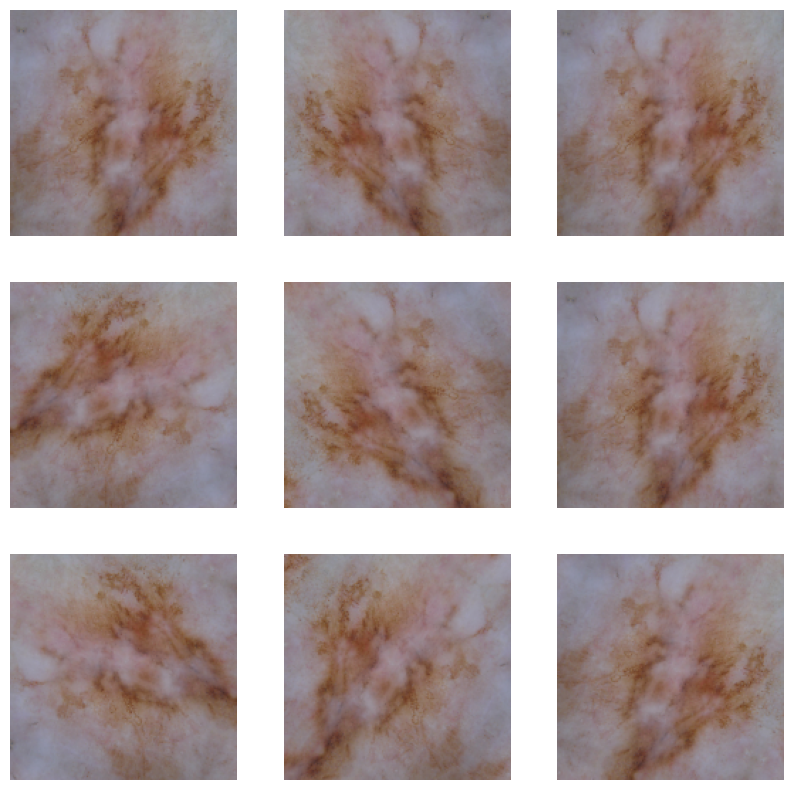

In [20]:
#Menampilkan data yang telah diaugmentasi
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Membuat Model Dasar dari Pre Trained MobileNetV2

### Kustomisasi dan Mengunduh Base Model

In [21]:
# Digunakan untuk memproses input gambar pada MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [22]:
# Digunakan untuk reskalasi rentang model
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [23]:
# Digunakan untuk melakukan normalisasi data berdasarkan reskalasi lambda dari variabel normalized_ds
import numpy as np
normalized_ds = train_dataset.map(lambda x, y: (rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Variabel first_image digunakan untuk mengambil indeks ke 0 atau data pertama pada dataset
first_image = image_batch[0]

# Mencetak gambar pertama dengan menampilkan nilai pixel minumum dan maksimum
print(np.min(first_image), np.max(first_image))

-0.7171569 0.6406864


In [24]:
# Membuat model dasar dari pre trained model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model1 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [25]:
# Mengambil semua batch data gambar
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model1(image_batch)

# Mencetak representasi fitur pada base_model1 berdasarkan image_batch
print(feature_batch.shape)

(32, 5, 5, 1280)


In [26]:
# Menonaktifkan pembaharuan bobot pada base_model1
base_model1.trainable = False

In [27]:
# Informasi atau ringkasan model base_model1
base_model1.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Membuat Model Berdasarkan Base Model


In [28]:
# Menghitung rata-rata feature_batch
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
# Membuat lapisan prediksi neuron
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [30]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model1(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model1 = tf.keras.Model(inputs, outputs)

In [31]:
base_learning_rate = 0.001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model1.summary()

# print("Pre Trained Model MobileNetV2:")
# plot_model(base_model1(),to_file='MobileNetV2.png', show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
loss0, accuracy0 = model1.evaluate(validation_dataset)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 8s 79ms/step - loss: 1.3308 - accuracy: 0.3688


In [34]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.33
initial accuracy: 0.37


### Checkpoint Untuk Menyimpan Bobot Model

Checkpoint digunakan untuk menyimpan bobot tiap iterasi. Bobot yang disimpan adalah val_accuracy, bobot yang disimpan hanya yang memiliki nilai tertinggi.

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint untuk menyimpan bobot terbaik tiap epochs

# Direktori penyimpanan bobot menggunakan gdrive
model_filepath = "/content/drive/MyDrive/Dataset/MobileNetV2/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_model1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

### Melatih Pre Trained Model

In [36]:
initial_epochs = 75

history = model1.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_model1])

Epoch 1/75
225/225 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.6565
Epoch 1: val_accuracy improved from -inf to 0.74171, saving model to /content/drive/MyDrive/Dataset/MobileNetV2/model-01-0.7417.hdf5
225/225 [==============================] - 24s 88ms/step - loss: 0.7981 - accuracy: 0.6565 - val_loss: 0.6039 - val_accuracy: 0.7417
Epoch 2/75
225/225 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.7471
Epoch 2: val_accuracy improved from 0.74171 to 0.74586, saving model to /content/drive/MyDrive/Dataset/MobileNetV2/model-02-0.7459.hdf5
225/225 [==============================] - 19s 80ms/step - loss: 0.5954 - accuracy: 0.7471 - val_loss: 0.5513 - val_accuracy: 0.7459
Epoch 3/75
225/225 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.7725
Epoch 3: val_accuracy improved from 0.74586 to 0.77072, saving model to /content/drive/MyDrive/Dataset/MobileNetV2/model-03-0.7707.hdf5
225/225 [==============================] 

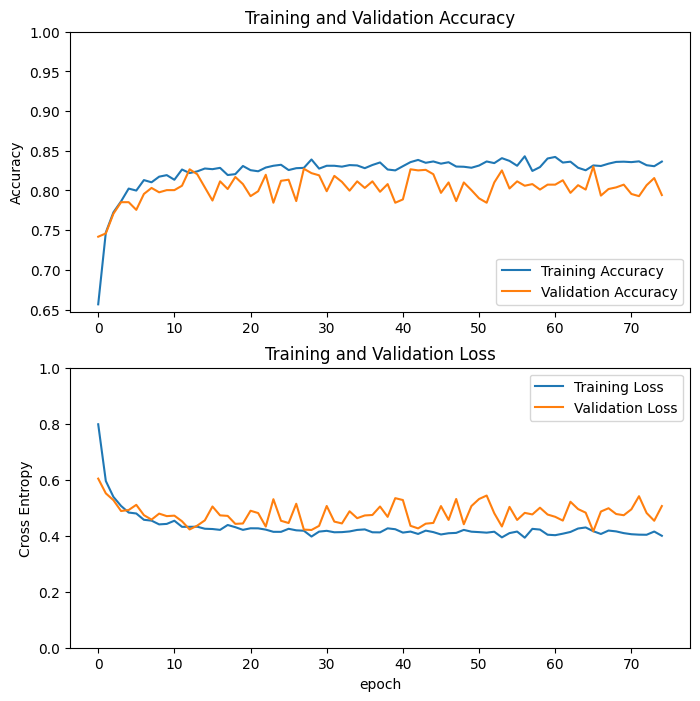

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Menambahkan Fine Tuning Model

In [38]:
# Mengubah menjadi True selama proses fine tune
base_model1.trainable = True

In [39]:
# Menghitung jumlah layer pada base_model1
print("Number of layers in the base model: ", len(base_model1.layers))

# Dilakukan fine tune mulai layer 100 ke atas
fine_tune_at = 100

# Membekukan layer 100 kebawah
for layer in base_model1.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [40]:
# model1.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               metrics=['accuracy'])

base_learning_rate = 0.001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [42]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model1.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[checkpoint_model1])

Epoch 75/100
224/225 [============================>.] - ETA: 0s - loss: 3.9624 - accuracy: 0.3410
Epoch 75: val_accuracy did not improve from 0.83011
225/225 [==============================] - 24s 85ms/step - loss: 3.9614 - accuracy: 0.3411 - val_loss: 1.4383 - val_accuracy: 0.3391
Epoch 76/100
225/225 [==============================] - ETA: 0s - loss: 2.9561 - accuracy: 0.3321
Epoch 76: val_accuracy did not improve from 0.83011
225/225 [==============================] - 19s 83ms/step - loss: 2.9561 - accuracy: 0.3321 - val_loss: 1.2222 - val_accuracy: 0.3363
Epoch 77/100
225/225 [==============================] - ETA: 0s - loss: 2.4389 - accuracy: 0.3332
Epoch 77: val_accuracy did not improve from 0.83011
225/225 [==============================] - 19s 82ms/step - loss: 2.4389 - accuracy: 0.3332 - val_loss: 1.4027 - val_accuracy: 0.3273
Epoch 78/100
225/225 [==============================] - ETA: 0s - loss: 1.9443 - accuracy: 0.3372
Epoch 78: val_accuracy did not improve from 0.83011
2

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

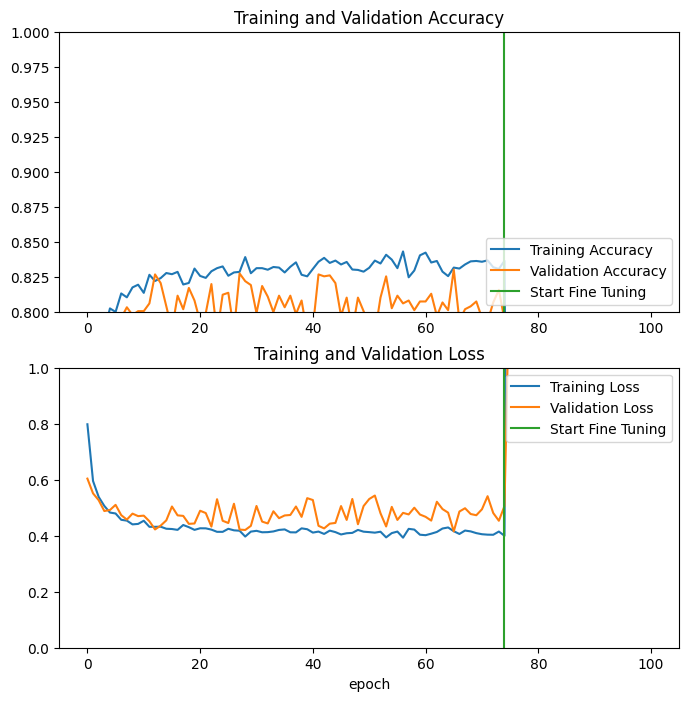

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
model1.save('MobileNetV2 (0,001).h5')

## Membuat Model Dasar dari Pre Trained EfficientNetB7

### Kustomisasi dan Mengunduh Base Model

In [46]:
# Digunakan untuk memproses input gambar pada EfficientNetB7
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [47]:
# Digunakan untuk reskalasi rentang model
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [48]:
# Digunakan untuk melakukan normalisasi data berdasarkan reskalasi lambda dari variabel normalized_ds
import numpy as np
normalized_ds = train_dataset.map(lambda x, y: (rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Variabel first_image digunakan untuk mengambil indeks ke 0 atau data pertama pada dataset
first_image = image_batch[0]

# Mencetak gambar pertama dengan menampilkan nilai pixel minumum dan maksimum
print(np.min(first_image), np.max(first_image))

-0.5058827 0.94211745


In [49]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model2 = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')

258076736/258076736 [==============================] - 14s 0us/step


In [50]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model2(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2560)


In [51]:
base_model2.trainable = False

In [52]:
base_model2.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 160, 160, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling_2[0][0]']            
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 160, 160, 3)  0          ['normalization[0][0

### Membuat Model Berdasarkan Base Model

In [53]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2560)


In [54]:
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [55]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model2(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model2 = tf.keras.Model(inputs, outputs)

In [56]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 7683      
                                                           

In [58]:
loss0, accuracy0 = model2.evaluate(validation_dataset)

46/46 [==============================] - 20s 213ms/step - loss: 1.1183 - accuracy: 0.3757


In [59]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.12
initial accuracy: 0.38


### Checkpoint Untuk Menyimpan Bobot Model

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint untuk menyimpan bobot terbaik tiap epochs

# Direktori penyimpanan bobot menggunakan gdrive
model_filepath = "/content/drive/MyDrive/Dataset/EfficientNetB7/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_model2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


### Melatih Pre Trained Model

In [61]:
initial_epochs = 75

history = model2.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_model2])

Epoch 1/75
225/225 [==============================] - ETA: 0s - loss: 0.7202 - accuracy: 0.6839
Epoch 1: val_accuracy improved from -inf to 0.70925, saving model to /content/drive/MyDrive/Dataset/EfficientNetB7/model-01-0.7093.hdf5
225/225 [==============================] - 79s 273ms/step - loss: 0.7202 - accuracy: 0.6839 - val_loss: 0.6822 - val_accuracy: 0.7093
Epoch 2/75
225/225 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.7432
Epoch 2: val_accuracy improved from 0.70925 to 0.75967, saving model to /content/drive/MyDrive/Dataset/EfficientNetB7/model-02-0.7597.hdf5
225/225 [==============================] - 61s 268ms/step - loss: 0.6031 - accuracy: 0.7432 - val_loss: 0.5760 - val_accuracy: 0.7597
Epoch 3/75
225/225 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.7643
Epoch 3: val_accuracy did not improve from 0.75967
225/225 [==============================] - 60s 263ms/step - loss: 0.5649 - accuracy: 0.7643 - val_loss: 0.5936 - val_a

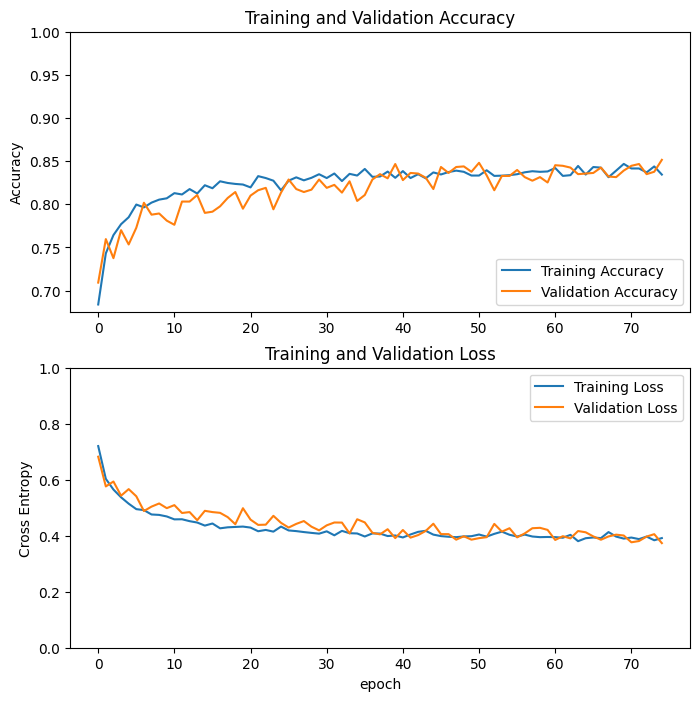

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
model2.save("Pelatihan EN 240240 0,0001.h5")

### Menambahkan Fine Tuning Model

In [64]:
# Mengubah menjadi True selama proses fine tune
base_model2.trainable = True

In [65]:
# Menghitung jumlah layer pada base_model2
print("Number of layers in the base model2: ", len(base_model2.layers))

# Dilakukan fine tune mulai layer 100 ke atas
fine_tune_at = 100

# Membekukan layer 100 kebawah
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model2:  814


In [66]:
# model2.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               metrics=['accuracy'])

base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 7683      
                                                           

In [68]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[checkpoint_model2])

Epoch 75/100
225/225 [==============================] - ETA: 0s - loss: 1.2821 - accuracy: 0.3335
Epoch 75: val_accuracy did not improve from 0.85152
225/225 [==============================] - 216s 819ms/step - loss: 1.2821 - accuracy: 0.3335 - val_loss: 1.0990 - val_accuracy: 0.3239
Epoch 76/100
225/225 [==============================] - ETA: 0s - loss: 1.0987 - accuracy: 0.3315
Epoch 76: val_accuracy did not improve from 0.85152
225/225 [==============================] - 180s 798ms/step - loss: 1.0987 - accuracy: 0.3315 - val_loss: 1.0988 - val_accuracy: 0.3315
Epoch 77/100
225/225 [==============================] - ETA: 0s - loss: 1.0987 - accuracy: 0.3264
Epoch 77: val_accuracy did not improve from 0.85152
225/225 [==============================] - 180s 798ms/step - loss: 1.0987 - accuracy: 0.3264 - val_loss: 1.0988 - val_accuracy: 0.3287
Epoch 78/100
225/225 [==============================] - ETA: 0s - loss: 1.0987 - accuracy: 0.3294
Epoch 78: val_accuracy did not improve from 0.8

In [69]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

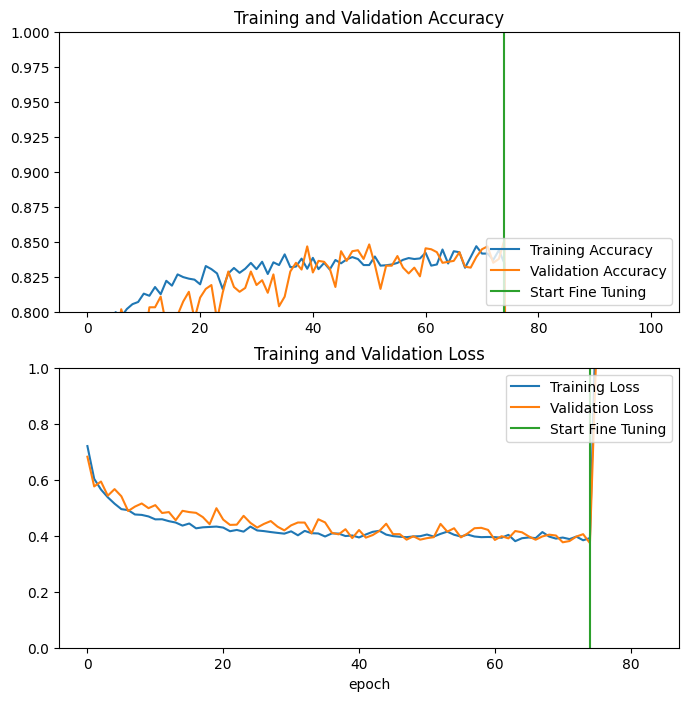

In [70]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [71]:
model2.save('EfficientNetB7_0,00001.h5')

## Stack Generalization Ensemble dengan Model MobileNetV2 dan EfficientNetB7



In [85]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('//content/MobileNetV2 (0,001).h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='MobileNetV2')
model_2 = load_model('/content/EfficientNetB7 (0,001).h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='EfficientNetB7')
models = [model_1, model_2]
model_input = Input(shape=(160, 160, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [86]:
base_learning_rate = 0.001
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobileNetV2 (Functional)       (None, 3)            2261827     ['input_6[0][0]']                
                                                                                                  
 EfficientNetB7 (Functional)    (None, 3)            64105370    ['input_6[0][0]']                
                                                                                                  
 average_1 (Average)            (None, 3)            0           ['MobileNetV2[0][0]',     

In [88]:
initial_epochs = 5

history = ensemble_model.fit(train_dataset,
                             epochs=initial_epochs,
                             validation_data=validation_dataset)

Epoch 1/5
225/225 [==============================] - 217s 821ms/step - loss: nan - accuracy: 0.3301 - val_loss: nan - val_accuracy: 0.3363
Epoch 2/5
225/225 [==============================] - 179s 795ms/step - loss: nan - accuracy: 0.3301 - val_loss: nan - val_accuracy: 0.3405
Epoch 3/5
225/225 [==============================] - 179s 793ms/step - loss: nan - accuracy: 0.3301 - val_loss: nan - val_accuracy: 0.3370
Epoch 4/5
225/225 [==============================] - 179s 793ms/step - loss: nan - accuracy: 0.3301 - val_loss: nan - val_accuracy: 0.3419
Epoch 5/5
225/225 [==============================] - 179s 793ms/step - loss: nan - accuracy: 0.3301 - val_loss: nan - val_accuracy: 0.3419


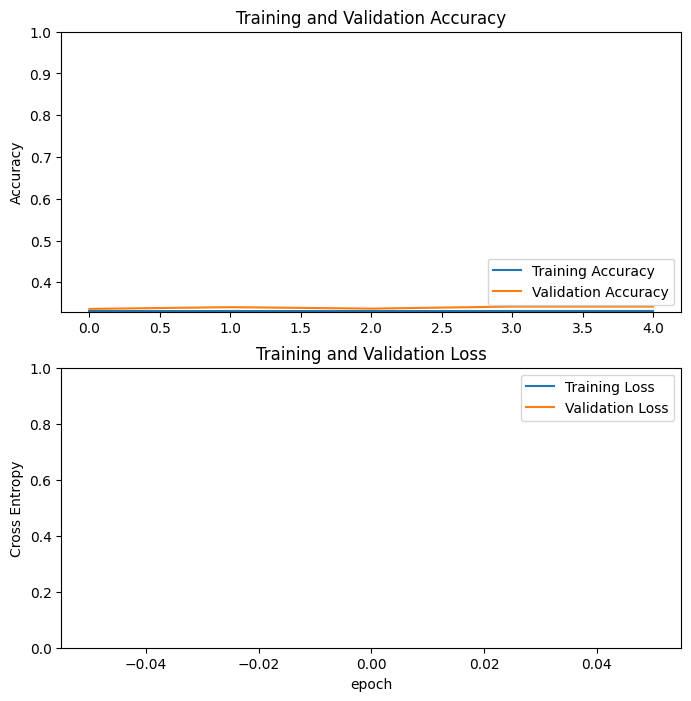

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [77]:
ensemble_model.save('Ensemble_Model.h5')

## Evaluasi dan Testing Model

In [90]:
loss, accuracy = ensemble_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

11/11 [==============================] - 3s 209ms/step - loss: nan - accuracy: 0.3438
Test accuracy : 0.34375


In [91]:
evaluasi_train = ensemble_model.evaluate(train_dataset, verbose=1)
evaluasi_val = ensemble_model.evaluate(validation_dataset, verbose=1)

print(f'''
---  Evaluasi  ---
Training = {evaluasi_train}
Validasi = {evaluasi_val}''')

46/46 [==============================] - 10s 203ms/step - loss: nan - accuracy: 0.3370

---  Evaluasi  ---
Training = [nan, 0.3301388919353485]
Validasi = [nan, 0.33701658248901367]


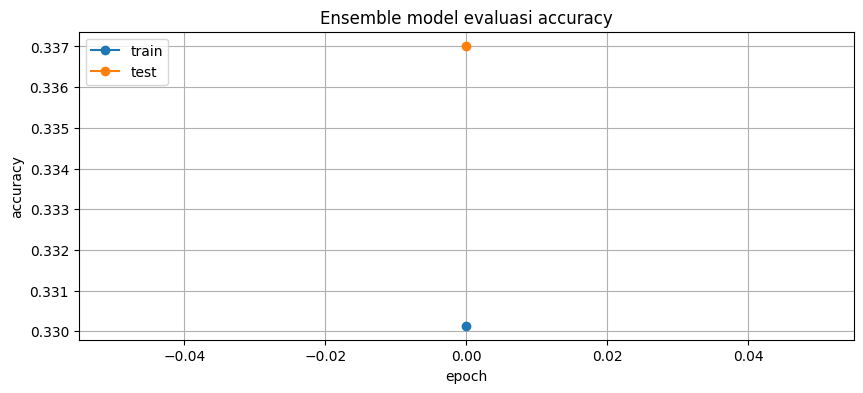

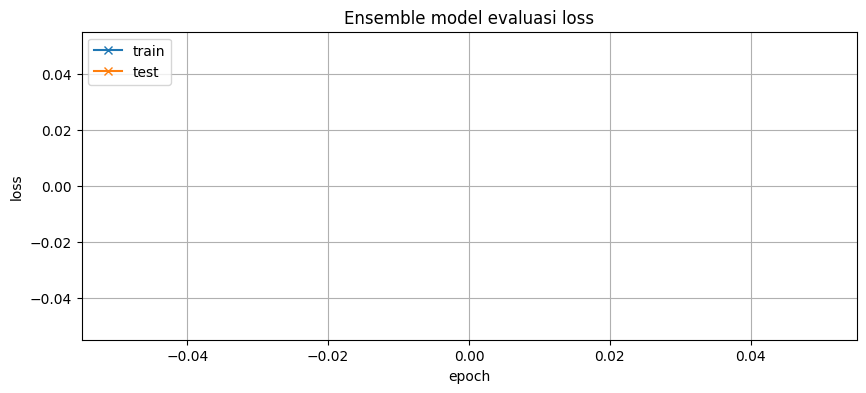

In [92]:
# Membuat plot evaluasi akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(evaluasi_train[1],marker='o')
plt.plot(evaluasi_val[1],marker='o')
plt.title('Ensemble model evaluasi accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot evaluasi loss model CNN
plt.figure(figsize=(10,4))
plt.plot(evaluasi_train[0],marker='x')
plt.plot(evaluasi_val[0],marker='x')
plt.title('Ensemble model evaluasi loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [93]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(160, 160))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = ensemble_model.predict(images, batch_size=BATCH_SIZE)
  print(classes)

  if classes[0][0] >= 0.5:
    print('Basal Cell Carcinoma')
  elif classes[0][1] >= 0.5:
    print('Melanoma')
  elif classes[0][2] >= 0.5:
    print('Squamous Cell Carcinoma')
  else:
    print('Your skin is healthy, keep it up! no disease detected.')

Saving Basal Cell Carcinoma_ Test_(1).jpg to Basal Cell Carcinoma_ Test_(1).jpg
Saving Melanoma_Test_ (14).jpg to Melanoma_Test_ (14).jpg
Saving Squamous Cell Carcinoma_Test_ (14).jpg to Squamous Cell Carcinoma_Test_ (14).jpg
1/1 [==============================] - 6s 6s/step
[[nan nan nan]]
Your skin is healthy, keep it up! no disease detected.
1/1 [==============================] - 0s 68ms/step
[[nan nan nan]]
Your skin is healthy, keep it up! no disease detected.
1/1 [==============================] - 0s 64ms/step
[[nan nan nan]]
Your skin is healthy, keep it up! no disease detected.
